# **Сравнение детекторов на примере детекции игроков в спорте**

**Какой кейс решаем:**

Необходимо обучить на целевом датасете (игроки в спорте) два типа детекторов: 1) Detectron2 (семейство R-CNN) и 2) Ultralytics (семейство YOLO).



**Краткая информация о данных:**

Внутри датасета находятся папки images_train (400 изображений) и images_test (100 изображений), а также файлы с аннотациями к ним: anno_train.json и anno_test.json. Файлы с аннотациями имеют следующую структуру:

image_name: {
     player_id: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
}
...

Здесь image_name - имя изображения в соответствующей папке,
player_id - id игрока в текущем изображении (в данном задании id не важен),
'box': [x,y,w,h] - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),
'team': int - id команды к которой принадлежит игрок в данном кадре (может принимать значения 0 или 1).



**Метрика качества:**

После обучения нужно замерить метрику mAP для разных моделей и сравнить результаты.

# Обучение и инференс детектора Detectron2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python

In [ ]:
import cv2

## Устанавливаем detectron2

In [ ]:
# Новый вариант:
!python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-d05jcgo1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-d05jcgo1
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 83.1 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [ ]:
# check pytorch installation:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
#assert torch.__version__.startswith("1.10")   # please manually install torch 1.10 if Colab changes its default version

2.4.1+cu121 True


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Запускаем предобученную модель на detectron2

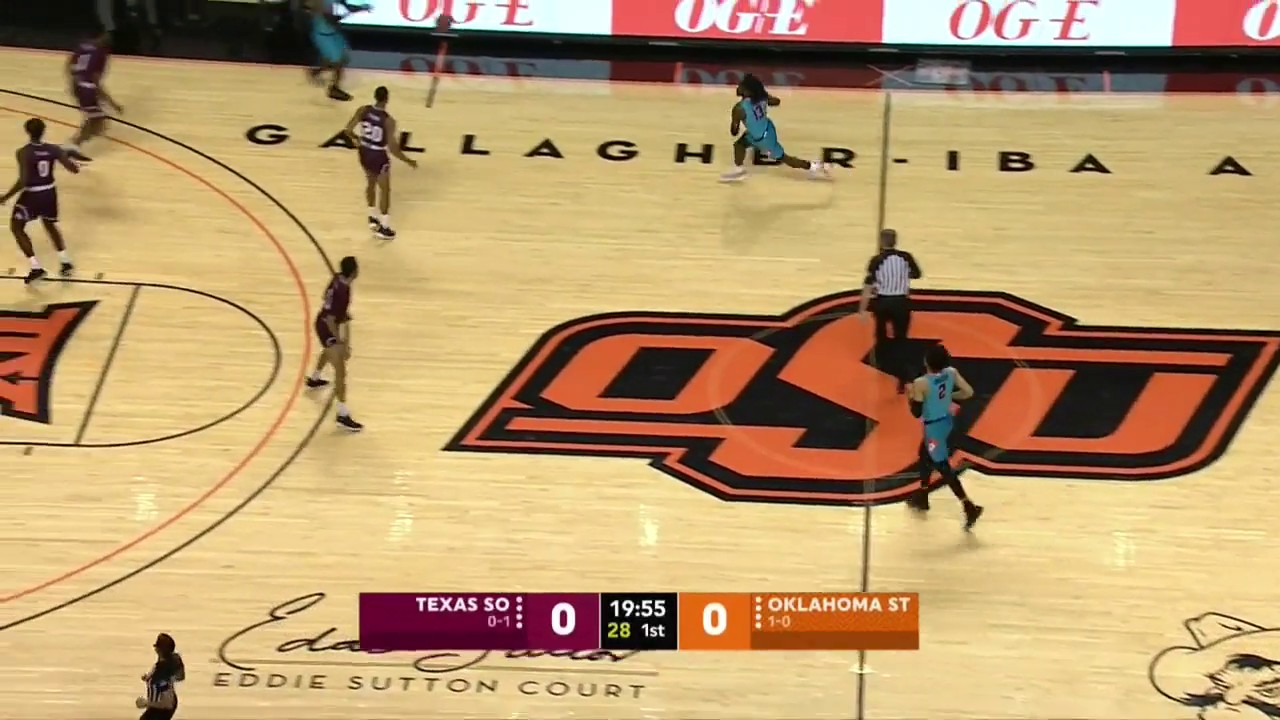

In [ ]:
im = cv2.imread('/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_train/000256.jpeg')
cv2_imshow(im)

Создадим конфиг для конкретной модели из detectron2 и инициализируем DefaultPredictor чтобы сделать инференс на изображении выше.

In [ ]:
model_name = "COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"

cfg = get_cfg()
# add project-specific config (e.g., TensorMask)
cfg.merge_from_file(model_zoo.get_config_file(model_name))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[10/02 08:55:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_C4_3x/138204752/model_final_298dad.pkl ...


model_final_298dad.pkl: 212MB [00:00, 242MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# Спецификацию по выходному формату можно найти здесь: https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 36, 36, 26, 26], device='cuda:0')
Boxes(tensor([[0.0000e+00, 1.1609e+02, 8.7043e+01, 2.8209e+02],
        [9.0035e+02, 3.4229e+02, 9.8192e+02, 5.2382e+02],
        [8.5984e+02, 2.2642e+02, 9.2529e+02, 3.5127e+02],
        [3.0607e+02, 2.5270e+02, 3.6344e+02, 4.2663e+02],
        [1.3876e+02, 6.3165e+02, 1.8591e+02, 7.1968e+02],
        [3.1970e+02, 8.1758e+01, 4.1990e+02, 2.4022e+02],
        [7.2140e+02, 7.6090e+01, 8.2600e+02, 1.7896e+02],
        [6.6385e+01, 2.8168e+01, 1.1717e+02, 1.5149e+02],
        [3.0674e+02, 3.8858e-01, 3.6426e+02, 1.0056e+02],
        [3.6898e+02, 2.1690e+02, 3.9511e+02, 2.4029e+02],
        [3.7052e+02, 2.2979e+02, 3.9570e+02, 2.4165e+02],
        [1.3479e+02, 6.9303e+02, 1.4996e+02, 7.1440e+02],
        [1.3950e+02, 6.7364e+02, 1.7727e+02, 7.1591e+02]], device='cuda:0'))


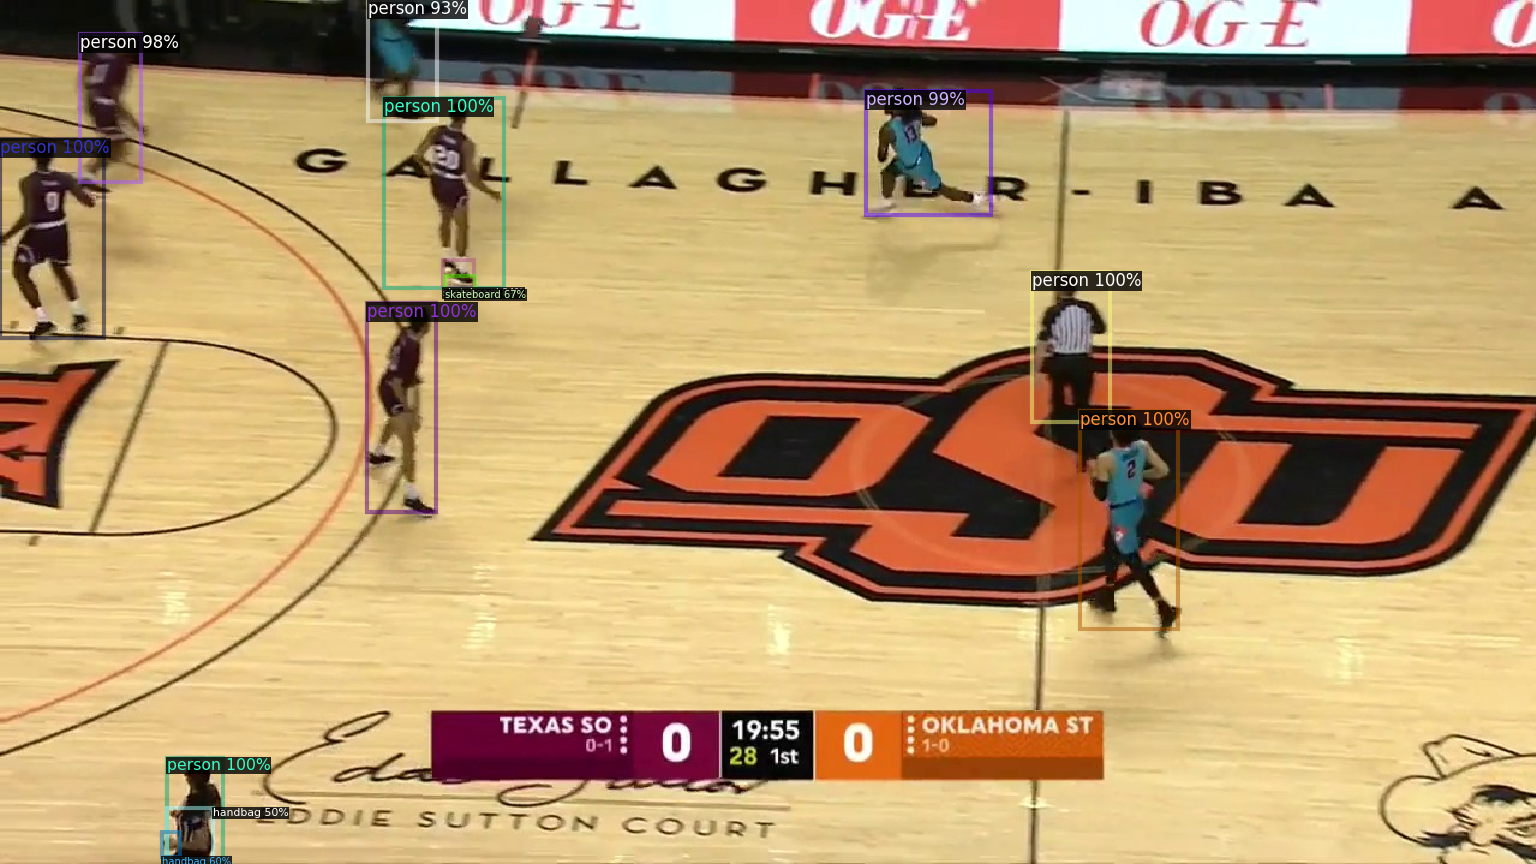

In [ ]:
# Используем визуализатор `Visualizer` для отрисовки предсказаний:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite('/content/drive/MyDrive/OTUS/detected_image.png', out.get_image()[:, :, ::-1])
cv2_imshow(out.get_image()[:, :, ::-1])

## Обучаем модель на новом датасете

Здесь мы рассмотрим как обучить готовую модель detectron2 на новом датасете.

Будем использовать датасет игроков 2 баскетбольных команд, который состоит только из 2 классов: Техас и Оклахома.
Будем обучать модель сегментации, используя уже готовую модель, обученную на COCO датасете Faster R-CNN.


## Подготовка датасета

Для начала зарегистрируем датасет "players" в detectron2, следуя [этому туториалу](https://detectron2.readthedocs.io/tutorials/datasets.html).
Этот датасет имеем свою собственную структуру, поэтому нам нужно написать функцию для парсинга и подготовки этого датасета к внутреннему формату датасетов detectron2. Аналогичные преобразования нужно будет сделать, если хотите использовать любой другой датасет.

In [ ]:
# Если используется датасет в формате COCO, то эту ячейку кода нужно заменить всего на 3 строки:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")
from detectron2.structures import BoxMode

def get_players_dicts(img_dir, d):
    json_file = "anno_train.json" if d == "images_train" else "anno_test.json"
    json_file_path = os.path.join(img_dir, json_file)
    with open(json_file_path) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    annotation_id = 1  # Уникальный ID для каждой аннотации
    for idx, (filename, v) in enumerate(imgs_anns.items()):
        record = {}

        img_dir_images_train = os.path.join(img_dir, d)
        img_path = os.path.join(img_dir_images_train, filename)

        # Проверка, что изображение загрузилось
        image = cv2.imread(img_path)
        if image is None:
            print(f"Ошибка: изображение не найдено по пути {img_path}")
            continue
        height, width = image.shape[:2]
        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for k, player_info in v.items():
            if k == "null":
                continue
            bbox = player_info["box"]
            team = player_info["team"]
            x, y, box_width, box_height = bbox
            x = x if x > 0 else 0
            y = y if y > 0 else 0
            box_width = box_width if box_width > 0 else 0
            box_height = box_height if box_height > 0 else 0
            area = box_width * box_height

            obj = {
                "id": annotation_id,
                "image_id": idx,
                "category_id": team,
                "bbox": [x * width, y * height, box_width * width, box_height * height],
                "bbox_mode": BoxMode.XYWH_ABS,
                "area": area * width * height,
                "iscrowd": 0,
            }
            objs.append(obj)
            annotation_id += 1
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["images_train", "images_test"]:
    DatasetCatalog.register("players_" + d, lambda d=d: get_players_dicts("/content/drive/MyDrive/datasets/otus_basketball_dataset_v2", d))
    MetadataCatalog.get("players_" + d).set(thing_classes=["team_0", "team_1"])
players_metadata = MetadataCatalog.get("players_images_train")

Визуализируем аннотации из рандомного сэмпла в train наборе чтобы убедиться что новый датасет подготовлен корректно:

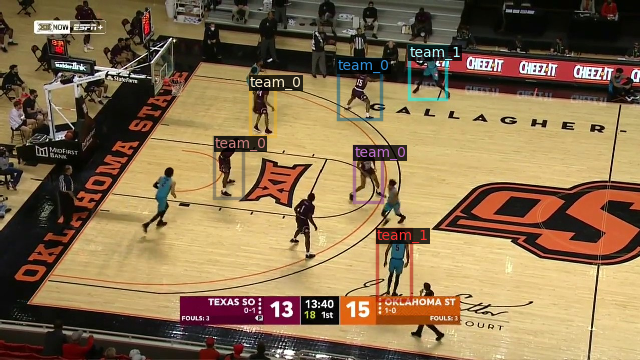

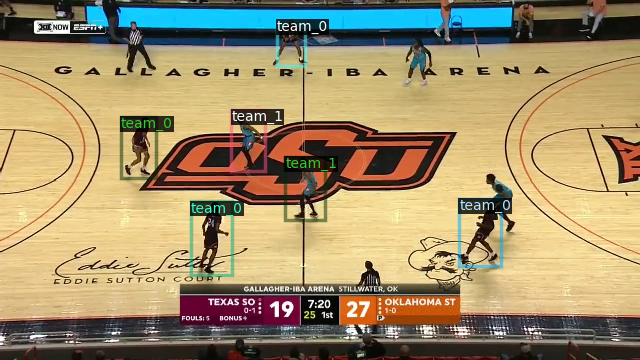

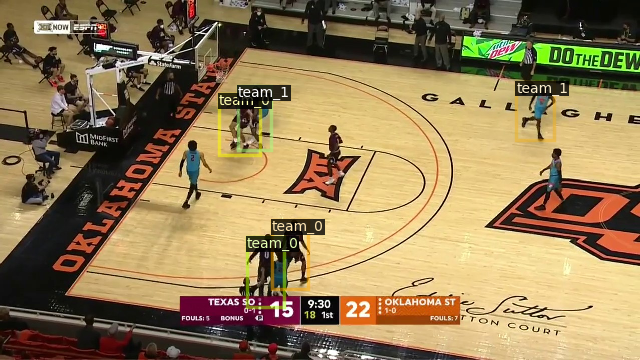

In [ ]:
dataset_dicts = get_players_dicts("/content/drive/MyDrive/datasets/otus_basketball_dataset_v2", "images_train")
num_samples = min(3, len(dataset_dicts))
for d in random.sample(dataset_dicts, num_samples):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=players_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
    print()

## Обучение!

Теперь мы можем дообучить модель R50-FPN Mask R-CNN, предобученную на COCO, на нашем новом датасете. Будем обучать 300 итераций (должно занять не больше нескольких минут, если используете GPU).

In [ ]:
from detectron2.engine import DefaultTrainer
import os

files = os.listdir("/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_train")
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
images = [file for file in files if file.endswith(image_extensions)]
TOTAL_NUM_IMAGES = len(images)

BATCH_SIZE = 128
MAX_ITER = 300

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_name))
cfg.DATASETS.TRAIN = ("players_images_train",)
cfg.DATASETS.TEST = ("players_images_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = int(MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES)
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# Выходная директория для сохранения моделей
# cfg.OUTPUT_DIR = "./output_basketball"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Тренировка модели
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/02 10:32:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/02 10:32:28 d2.engine.train_loop]: Starting training from iteration 0
[10/02 10:32:47 d2.utils.events]:  eta: 0:22:53  iter: 19  total_loss: 2.1  loss_cls: 1.139  loss_box_reg: 0.8659  loss_rpn_cls: 0.06792  loss_rpn_loc: 0.02299    time: 0.9189  last_time: 0.8798  data_time: 0.0256  last_data_time: 0.0079   lr: 4.9953e-06  max_mem: 3874M
[10/02 10:33:05 d2.utils.events]:  eta: 0:22:37  iter: 39  total_loss: 1.982  loss_cls: 1.075  loss_box_reg: 0.8401  loss_rpn_cls: 0.07732  loss_rpn_loc: 0.02299    time: 0.9208  last_time: 0.9143  data_time: 0.0115  last_data_time: 0.0064   lr: 9.9902e-06  max_mem: 3874M
[10/02 10:33:23 d2.utils.events]:  eta: 0:21:51  iter: 59  total_loss: 1.902  loss_cls: 0.9656  loss_box_reg: 0.8433  loss_rpn_cls: 0.07123  loss_rpn_loc: 0.01862    time: 0.9036  last_time: 0.9075  data_time: 0.0123  last_data_time: 0.0074   lr: 1.4985e-05  max_mem: 3874M
[10/02 10:33:40 d2.utils.events]:  eta: 0:21:08  iter: 79  total_loss: 1.797  loss_cls: 0.8305  loss_box_reg

## Инференс и оценка обученной модели
Теперь можно протестировать обученную модель на валидационном сете. Сперва создадим предиктор для только что обученной модели:

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[10/02 10:57:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Далее, выберем несколько случайных семплов и визуализируем результаты предсказаний.

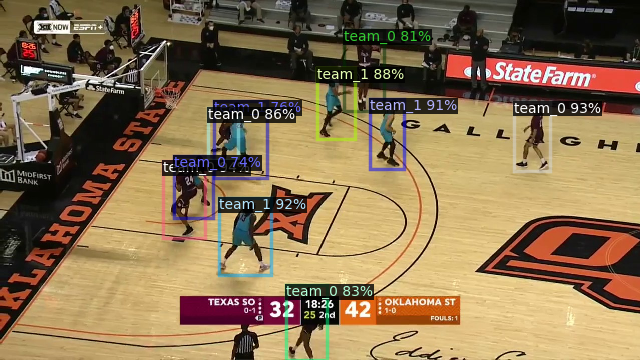

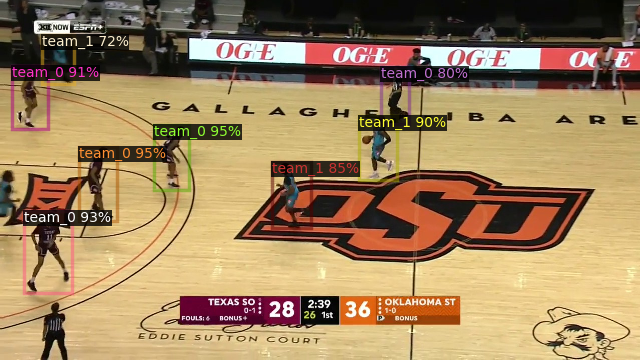

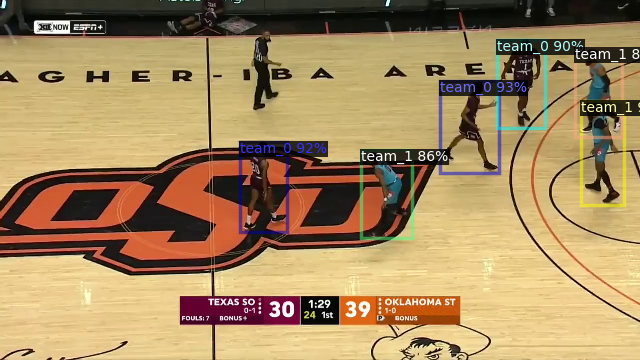

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_players_dicts('/content/drive/MyDrive/datasets/otus_basketball_dataset_v2', 'images_test')
num_samples = min(3, len(dataset_dicts))
for d in random.sample(dataset_dicts, num_samples):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=players_metadata,
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    print()

Оценим производительность модели используя AP метрику, реализованную в COCO API. Это должно дать AP=~70!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("players_images_test", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "players_images_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [10/02 10:58:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/02 10:58:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/02 10:58:07 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/02 10:58:07 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[10/02 10:58:07 d2.data.common]: Serialized dataset takes 0.07 MiB
[10/02 10:58:07 d2.evaluation.evaluator]: Start inference on 100 batches
[10/02 10:58:14 d2.evaluation.evaluator]: Inference done 11/100. Dataloading: 0.0045 s/iter. Inference: 0.5683 s/iter. Eval: 0.0004 s/iter. Total: 0.5732 s/iter. ETA=0:00:51
[10/02 10:58:19 d2.evaluation.evaluator]: Inference done 20/100. Dataloading: 0.0041 s/iter. Inference: 0.5753 s/i

In [ ]:
ap_detector2 = 35.096

# Обучение и инференс детектора YOLOv8 из ultralytics

### Устанавливаем ultralytics

In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.4/881.4 kB 52.0 MB/s eta 0:00:00


### Импортируем ultralytics и другие вспомогательные библиотеки

In [ ]:
import ultralytics
ultralytics.checks()
import json
import os
from ultralytics import YOLO

from IPython.display import Image     # Для визуализации в колабе

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.5/112.6 GB disk)


In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

# ! yes | unzip drive/MyDrive/OTUS/otus_basketball_dataset_v2.zip -d ./datasets/

In [ ]:
def convert_annotations_to_txt(annotations_path, output_dir):
    # Чтение JSON файла с аннотациями
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)

    # Проход по каждому изображению и его объектам
    for image_name, objects in annotations.items():
        # Создание файла с таким же именем, как изображение, но с расширением .txt
        txt_filename = os.path.splitext(image_name)[0] + ".txt"
        txt_filepath = os.path.join(output_dir, txt_filename)

        with open(txt_filepath, 'w') as txt_file:
            for obj_id, obj_data in objects.items():
                team = obj_data['team']  # Первая цифра - team
                box = obj_data['box']    # Координаты из box
                box0 = box[0] if box[0] > 0 else 0
                box1 = box[1] if box[1] > 0 else 0
                box2 = box[2] if box[2] > 0 else 0
                box3 = box[3] if box[3] > 0 else 0

                # Записываем строку в формате team x_center y_center width height
                txt_file.write(f"{team} {box0} {box1} {box2} {box3}\n")

    print(f"Аннотации успешно конвертированы в файлы .txt в папке {output_dir}")

# Формируем train аннотации
annotations_path_train = "/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/anno_train.json"
output_dir_train = "/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_train"
convert_annotations_to_txt(annotations_path_train, output_dir_train)
# Аннотации test аннотации
annotations_path_test = "/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/anno_test.json"
output_dir_test = "/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test"
convert_annotations_to_txt(annotations_path_test, output_dir_test)

Аннотации успешно конвертированы в файлы .txt в папке /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_train
Аннотации успешно конвертированы в файлы .txt в папке /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test


anno_test.json	anno_train.json  images_test  images_test.cache  images_train  images_train.cache
078176.jpeg  080362.txt   081851.jpeg  084592.txt   088312.jpeg  092506.txt   095194.jpeg
078176.txt   080432.jpeg  081851.txt   085127.jpeg  088312.txt	 092576.jpeg  095194.txt
078246.jpeg  080432.txt   081921.jpeg  085127.txt   088382.jpeg  092576.txt   095264.jpeg
078246.txt   080502.jpeg  081921.txt   085197.jpeg  088382.txt	 092646.jpeg  095264.txt
078477.jpeg  080502.txt   082942.jpeg  085197.txt   090712.jpeg  092646.txt   095334.jpeg
078477.txt   080604.jpeg  082942.txt   085271.jpeg  090712.txt	 092716.jpeg  095334.txt
078547.jpeg  080604.txt   083138.jpeg  085271.txt   091202.jpeg  092716.txt   095404.jpeg
078547.txt   080674.jpeg  083138.txt   085341.jpeg  091202.txt	 092786.jpeg  095404.txt
078617.jpeg  080674.txt   083208.jpeg  085341.txt   091272.jpeg  092786.txt   095474.jpeg
078617.txt   080744.jpeg  083208.txt   085411.jpeg  091272.txt	 092959.jpeg  095474.txt
078687.jpeg  

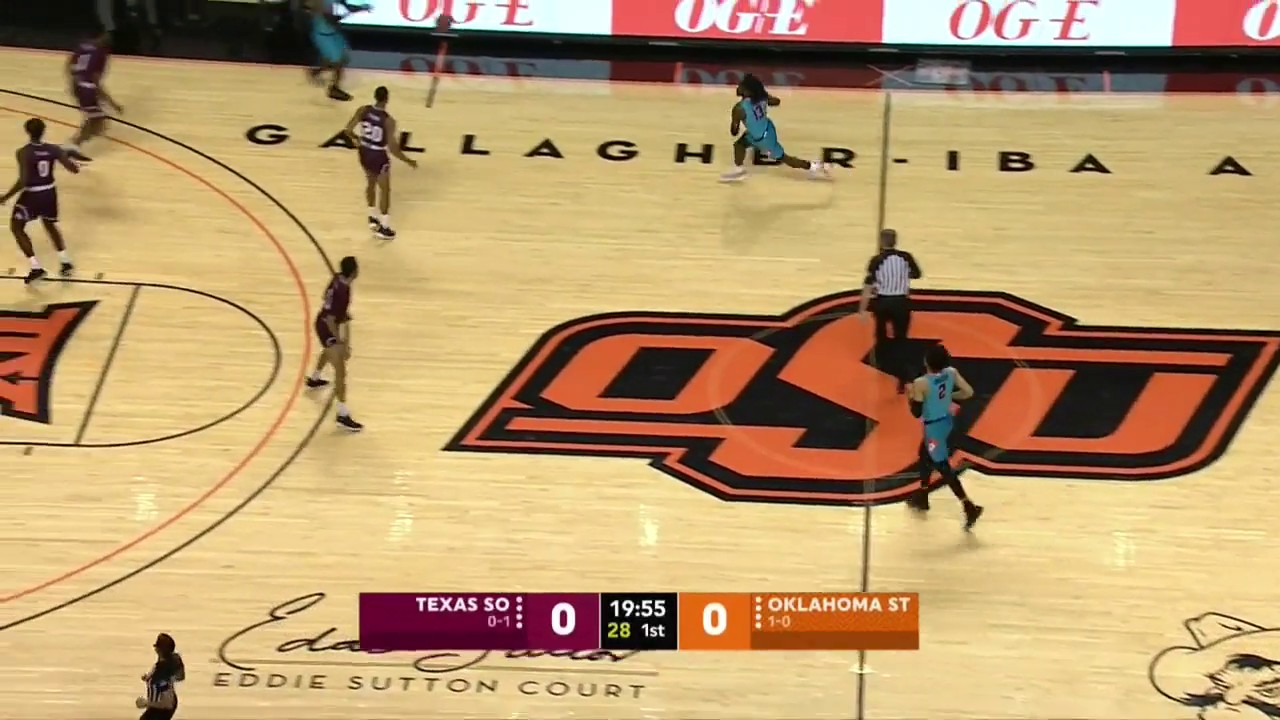

0 0.24962628403460746 0.11140376121522681 0.0671472597220639 0.23091108578361821
0 0.2266387320057002 0.34866911737913475 0.052639411719238895 0.24951755651285445
1 0.6931557525618904 0.4731945228412747 0.0732743736875129 0.26080628961483754
0 0.5704670267626252 0.09034004598823629 0.06753896019904879 0.16664101780646795
0 0.020572210473597696 0.035224593833640766 0.05414966499252986 0.20089679859302662


In [ ]:
# Структура датасета:
! ls /content/drive/MyDrive/datasets/otus_basketball_dataset_v2
! ls /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test

# Визуалилизируем пример изображения:
display(Image('/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_train/000256.jpeg', width=640))

# Проверим файл аннотаций:
! cat /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_train/000256.txt

### Подготовим датасет для YOLOv8
Создадим YAML-файл с описанием датасета

In [ ]:
! touch otus_basketball_dataset_v2.yaml
! echo "path: /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/" > otus_basketball_dataset_v2.yaml
! echo "train: 'images_train'" >> otus_basketball_dataset_v2.yaml
! echo "val: 'images_test'" >> otus_basketball_dataset_v2.yaml
! echo "names: " >> otus_basketball_dataset_v2.yaml
! echo "  0: 'team_0'" >> otus_basketball_dataset_v2.yaml
! echo "  1: 'team_1'" >> otus_basketball_dataset_v2.yaml
!cat otus_basketball_dataset_v2.yaml

path: /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/
train: 'images_train'
val: 'images_test'
names: 
  0: 'team_0'
  1: 'team_1'


### Обучим детектор YOLOv8 на этом датасете

---



In [ ]:
# Очистим папку с результатами:
! rm -rf runs/detect

In [ ]:
# Запускаем обучение:
! yolo detect train model=yolov8n.pt imgsz=640 data=otus_basketball_dataset_v2.yaml epochs=15 batch=16 name=yolov8n_custom

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=otus_basketball_dataset_v2.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

In [ ]:
# Сохраним обученную модель:
! cp runs/detect/yolov8n_custom/weights/best.pt /content/drive/MyDrive/OTUS/custom_yolov8_best.pt

cp: cannot stat 'runs/detect/yolov8n_custom/weights/best.pt': No such file or directory


### Обучим детектор YOLOv8 на этом датасете с нуля

In [ ]:
! yolo train model=yolov8n.yaml imgsz=640 data=otus_basketball_dataset_v2.yaml epochs=15 batch=16 name=yolov8n_custom_from_scratch

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=otus_basketball_dataset_v2.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom_from_scratch2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

In [ ]:
# Сохраним обученную модель:
! cp runs/detect/yolov8n_custom_from_scratch2/weights/best.pt /content/drive/MyDrive/OTUS/custom_yolov8_from_scratch_best.pt

## Протестируем обученную модель и сравним ее с дефолтной моделью "из коробки":

### Делаем предсказание (детекцию) используя обученную на наших данных модель:

In [ ]:
!yolo predict model='/content/drive/MyDrive/OTUS/custom_yolov8_best.pt' source='/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test/078176.jpeg'

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 186 layers, 2,684,758 parameters, 0 gradients, 6.8 GFLOPs

image 1/1 /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test/078176.jpeg: 384x640 5 team_0s, 5 team_1s, 144.5ms
Speed: 4.4ms preprocess, 144.5ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


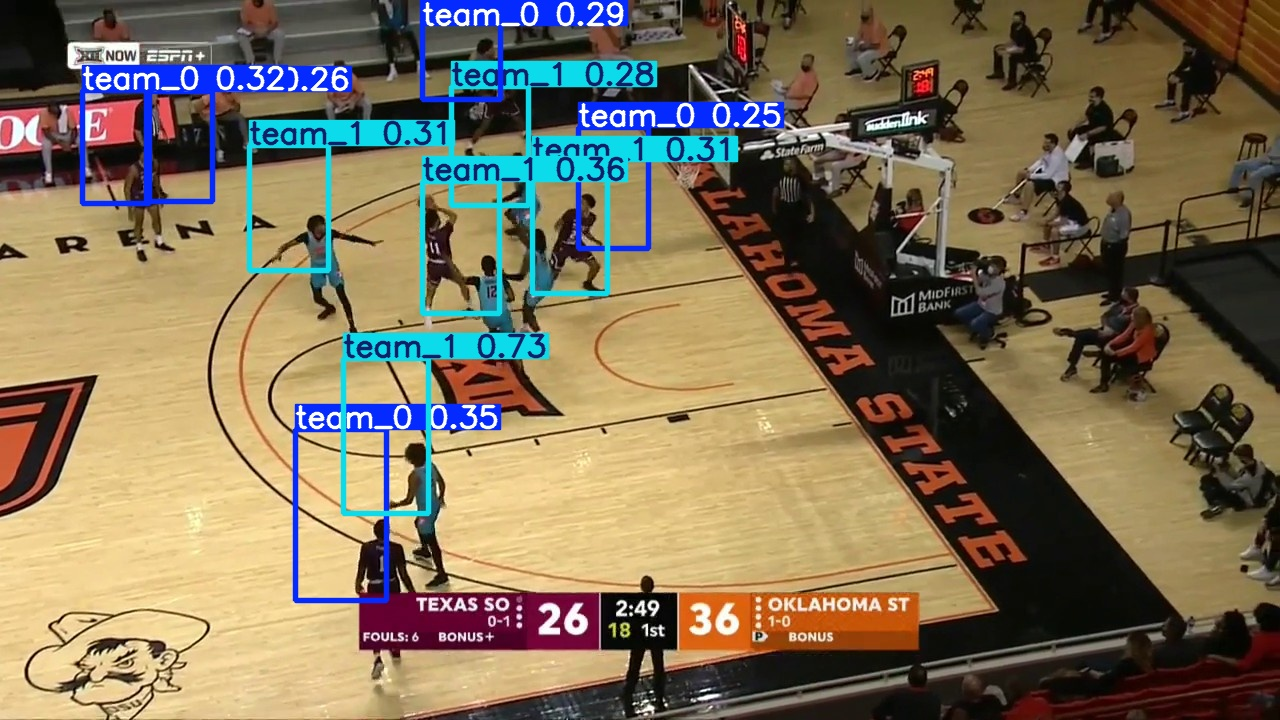

In [ ]:
# Визуалилизируем результат детекции обученной моделью:
display(Image('runs/detect/predict/078176.jpeg', width=640))

In [ ]:
# Оценка обученной модели на тестовом наборе данных
model = YOLO('/content/drive/MyDrive/OTUS/custom_yolov8_best.pt')
results = model.val()

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,684,758 parameters, 0 gradients, 6.8 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 143MB/s]
val: Scanning /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


                   all        100        660        0.4       0.69      0.399      0.201
                team_0        100        377      0.514      0.666      0.523      0.264
                team_1        100        283      0.287      0.714      0.275      0.138
Speed: 2.0ms preprocess, 4.9ms inference, 0.0ms loss, 13.1ms postprocess per image
Results saved to runs/detect/val3


### Делаем предсказание (детекцию) используя обученную модель с нуля:


In [ ]:
!yolo predict model='/content/drive/MyDrive/OTUS/custom_yolov8_from_scratch_best.pt' source='/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test/078176.jpeg' name="predict_from_scratch"

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 186 layers, 2,684,758 parameters, 0 gradients, 6.8 GFLOPs

image 1/1 /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test/078176.jpeg: 384x640 2 team_1s, 209.5ms
Speed: 5.4ms preprocess, 209.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict_from_scratch
💡 Learn more at https://docs.ultralytics.com/modes/predict


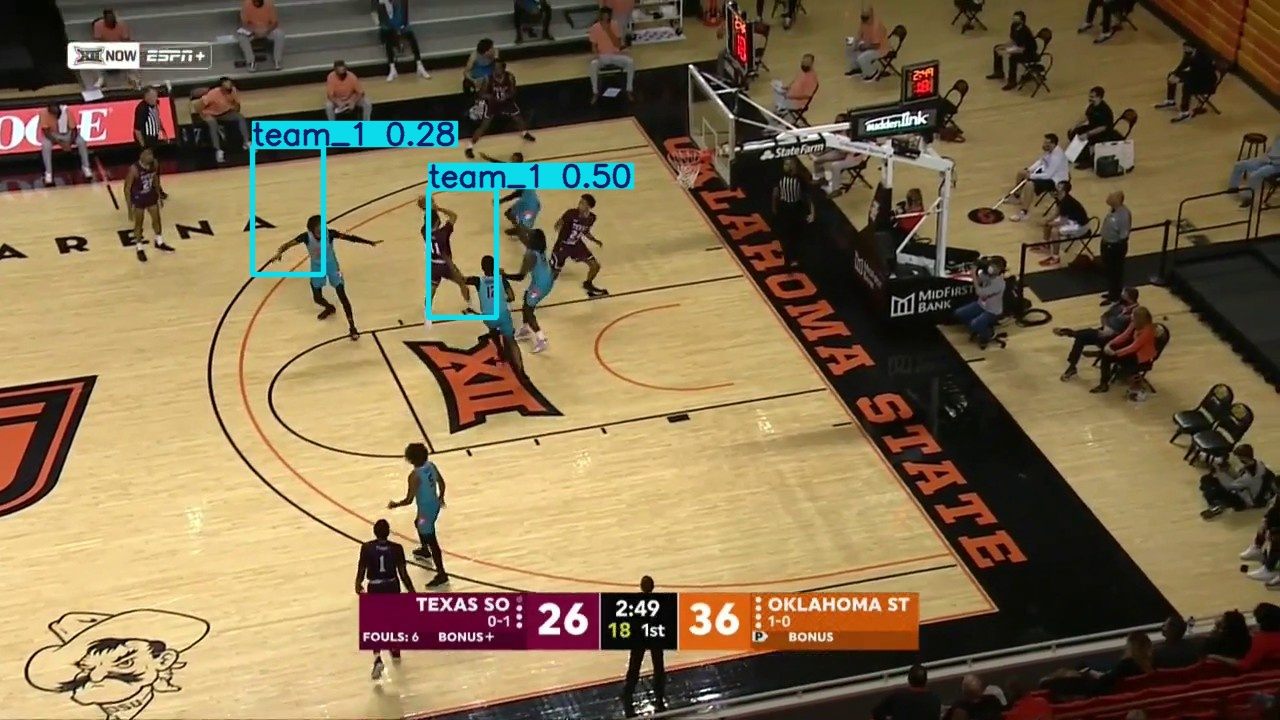

In [ ]:
# Визуалилизируем результат детекции моделью с нуля:
display(Image('runs/detect/predict_from_scratch/078176.jpeg', width=640))

In [ ]:
# Оценка обученной с нуля модели на тестовом наборе данных
model = YOLO('/content/drive/MyDrive/OTUS/custom_yolov8_from_scratch_best.pt')
results_from_scratch = model.val()

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 186 layers, 2,684,758 parameters, 0 gradients, 6.8 GFLOPs


val: Scanning /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.86s/it]


                   all        100        660      0.287      0.527      0.309      0.122
                team_0        100        377      0.307      0.393      0.277      0.109
                team_1        100        283      0.266      0.661      0.341      0.135
Speed: 2.4ms preprocess, 161.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val5


### Делаем предсказание (детекцию) используя дефолтную модель:


In [ ]:
!yolo predict model=yolov8n.pt source='/content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test/078176.jpeg' # predict with official model

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/drive/MyDrive/datasets/otus_basketball_dataset_v2/images_test/078176.jpeg: 384x640 19 persons, 161.0ms
Speed: 3.6ms preprocess, 161.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


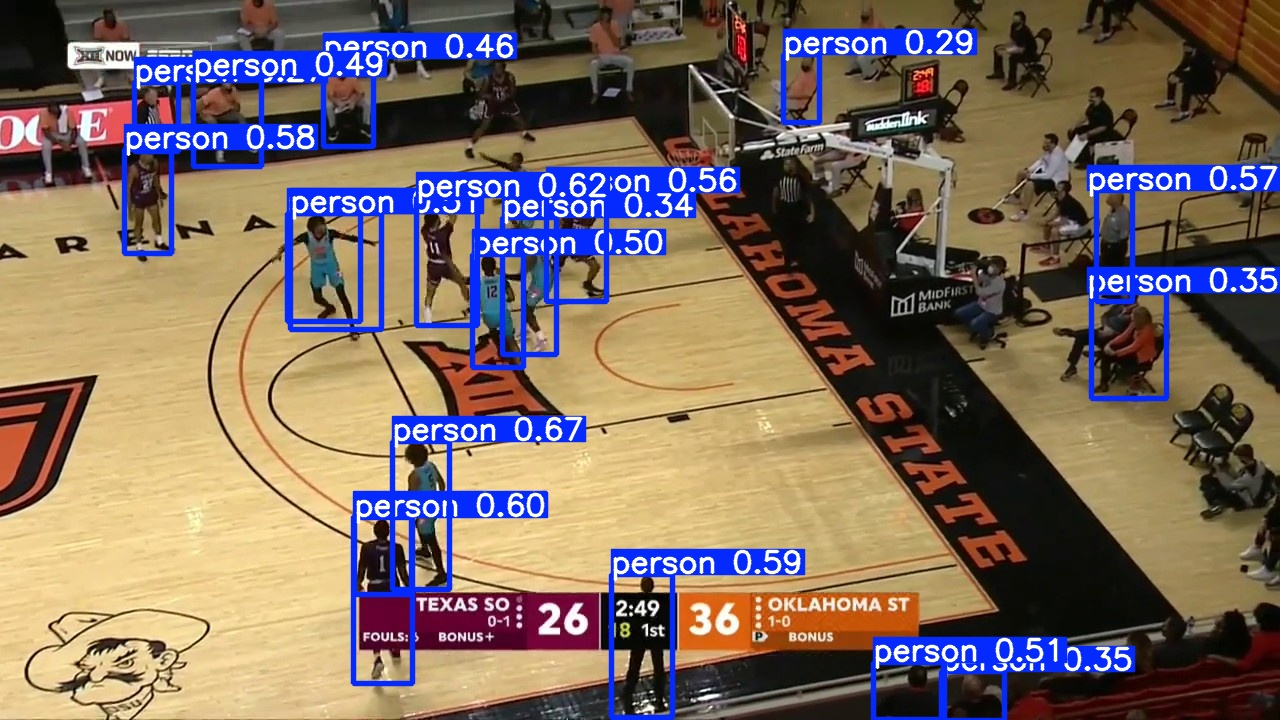

In [ ]:
# Визуалилизируем результат детекции дефолтной моделью:
display(Image('runs/detect/predict2/078176.jpeg', width=640))

In [ ]:
model = YOLO('yolov8n.pt')
results_default = model.val()

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /content/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [20:24<00:00,  3.91s/it]


                   all       5000      36335      0.633      0.475      0.521      0.371
                person       2693      10777      0.754      0.673      0.745      0.514
               bicycle        149        314      0.687      0.392      0.457      0.265
                   car        535       1918      0.646      0.515      0.561      0.364
            motorcycle        159        367       0.71       0.58      0.655      0.414
              airplane         97        143      0.814      0.766      0.832      0.653
                   bus        189        283      0.746      0.643      0.739       0.62
                 train        157        190      0.798       0.77      0.834      0.646
                 truck        250        414      0.549      0.399      0.435      0.293
                  boat        121        424      0.583        0.3      0.377       0.21
         traffic light        191        634      0.644      0.345      0.409      0.211
          fire hydran

# Итоги

## Сравнение метрик mAP50:

**Detectron2**: 0.579

**Ultralytics (предобученная)**: 0.399

**Ultralytics (обученная с нуля)**: 0.309

**Ultralytics (из коробки)**: 0.745

## Скорость обучения:

**Detectron2**: Средняя, но требует продвинутых вычислительных ресурсов (GPU)

**Ultralytics (предобученная)**: Медленная

**Ultralytics (обученная с нуля)**: Очень медленная

**Ultralytics (из коробки)**: Мгновенная (не нужно обучать)

## Эффект от предобучения:

**Detectron2**: Заметно улучшает результат

**Ultralytics (предобученная)**: Улучшает результат

**Ultralytics (обученная с нуля)**: Нет предобучения (нужен полный цикл)

**Ultralytics (из коробки)**: Модель предобучена, но не оптимизирована для задачи

## Удобство работы:

**Detectron2**: Гибкая, но достаточно сложна в освоении

**Ultralytics (предобученная)**: Простая в использовании, готовая к обучению

**Ultralytics (обученная с нуля)**: Интуитивно понятная, но требует времени на обучение

**Ultralytics (из коробки)**: Легкая в использовании

1. Лучшие результаты для решения задачи детекции и классификации игроков на 2 баскетбольные команды показала библиотека Detectron2 с map50 = 0.579 и средней скоростью обучения.
2. Также можно использовать YOLO8 от Ultralytics, предобученную на кастомном датасете, но использовать больше времени и вычислительных ресурсов для предобучения модели